# 📊 Customer Churn Analysis with BigQuery & Python 

## **Introduction**
This notebook is part of this **customer churn prediction project**, where we analyze bank customer data using **Google BigQuery** and **Python**. Our goal is to identify key factors influencing customer retention and to build a predictive model based on our findings.

## **🔗 Key Milestones Achieved So Far**
✅ **Cloud Integration**: We set up a **Google Cloud Service Account** to securely connect Kaggle datasets with BigQuery.  
✅ **Database Setup**: The dataset was uploaded to **BigQuery** for efficient querying and analysis.  
✅ **Local Execution**: Instead of downloading large files, we now run **SQL queries directly from this notebook** and retrieve data as Pandas DataFrames.  

## **📌 Current Focus**
🔹 Writing and executing **SQL queries** in BigQuery to explore churn-related patterns.  
🔹 Using **Python & Pandas** to analyze query results and create **visualizations**.  
🔹 Investigating feature selection techniques to identify the most relevant variables for churn prediction.  

## **🚀 Next Steps & Production Plan**
🔜 Transitioning from exploratory analysis to **machine learning modeling**.  
🔜 Designing a **CI/CD pipeline** for automating data ingestion and model updates.  
🔜 Deploying insights into a **dashboard or API** for real-time churn monitoring.  

Let’s dive into the data and extract meaningful insights! 🔍📈

# 📘 **Notebook Structure & Documentation** 🏗️  

To ensure clarity and maintainability, this notebook follows a structured approach, separating each key process into well-defined sections. Each section includes a detailed explanation of the code, making it easier to understand and extend.  

---

## **1️⃣ Setting Up the Environment & Authentication 🔐**

### **1.1 Importing Required Libraries 📦**  
Before interacting with **Google BigQuery** and **Kaggle**, we need to import the necessary Python libraries.  

In [2]:
import os
import pandas as pd
from google.cloud import bigquery

📌 **Explanation**:  
- `os`: Used for handling environment variables and system-level operations.  
- `pandas`: Essential for working with data in DataFrames.  
- `bigquery`: The **Google Cloud SDK** library for interacting with BigQuery.  


---

### **1.2 Setting Up Service Account Credentials 🛡️**  
To connect to BigQuery securely, we store the service account credentials in an **environment variable** instead of hardcoding them in the script.  

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/workspaces/ABCBankChurnRate/.config/sa_credentials.json"

📌 **Explanation**:  
- This ensures that **Google Cloud authentication** is handled securely.  
- 🔴 **Question**: *Is this safe enough?* Yes, as long as the `.json` file is properly **gitignored** and its name does not contain sensitive information. 

---

### **1.3 Initializing BigQuery Client & Project Verification 🏢**  

In [4]:
client = bigquery.Client()
print(client.project)

kagglebigquerybankchurn


📌 **Explanation**:  
- `bigquery.Client()` initializes the BigQuery connection.  
- `client.project` ensures that authentication was successful by printing the **associated GCP project ID**.  
- **Is this necessary?** No, but it's a good debugging step to verify access.  

---

## **2️⃣ Fetching the Dataset from Kaggle 📥**  

### **2.1 Importing the Kaggle API & Handling Authentication 🔑**  


In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi
import glob

📌 **Explanation**:  
- `KaggleApi()`: Enables programmatic access to **Kaggle datasets**.  
- `glob`: Useful for searching and handling downloaded files.  

---

### **2.2 Setting Kaggle Credentials from Environment Variables 🔑**  

In [6]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set Kaggle credentials from environment variables
if 'KAGGLE_USERNAME' not in os.environ or 'KAGGLE_KEY' not in os.environ:
	raise EnvironmentError("Kaggle credentials not found in environment variables")

📌 **Explanation**:  
- Ensures that the Kaggle credentials are correctly set in the environment.  
- Raises an error if the credentials are missing.  

---

### **2.3 Downloading the Kaggle Dataset 🚀**  

In [7]:

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()  # Uses the environment variable for authentication


# Define Kaggle dataset reference
dataset_name = "gauravtopre/bank-customer-churn-dataset"  # Replace with the actual Kaggle dataset
download_path = "/tmp"  # Temporary location, not inside this repo

# Download dataset (ZIP file)
api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# Find the downloaded CSV file
csv_files = glob.glob(f"{download_path}/*.csv")
assert len(csv_files) > 0, "No CSV files found. Check dataset name."
csv_file_path = csv_files[0]  # Assuming the dataset has a single CSV file

print(f"✅ Dataset downloaded: {csv_file_path}")

Dataset URL: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset
✅ Dataset downloaded: /tmp/Bank Customer Churn Prediction.csv


📌 **Explanation**:  
- **Authenticates the Kaggle API**.  
- **Downloads & extracts** the dataset to `/tmp` (a temporary folder, avoiding repo clutter).  
- Uses `glob` to locate the downloaded **CSV file**.  

---

## **3️⃣ Uploading Dataset to BigQuery 📤**  

### **3.1 Initializing BigQuery Client 🎯**  


In [8]:
from google.cloud import bigquery

# Initialize BigQuery client
bq_client = bigquery.Client()

📌 **Question**: Should the **client variable** have a different name?  
✔️ Yes! To avoid confusion, we renamed the **BigQuery client** as `bq_client`, since we previously initialized a `client` variable for Kaggle.  

---

## 🔍 **Step 3.2: Ensuring Dataset and Table Exist in BigQuery**


In this step, we ensure that our **BigQuery dataset and table** are correctly set up before running queries. The code performs three key actions:

### 🏗 **1. Initialize BigQuery Client**

In [9]:

bq_client = bigquery.Client()

- This creates a **client instance** to interact with BigQuery.
- It automatically detects the **Google Cloud project** tied to our credentials.

---

### 📂 **2. Define Dataset and Table Details**

In [10]:
# Define dataset and table details
project_id = bq_client.project  # Auto-fetch project ID
dataset_id = f"{project_id}.churn_analysis"
table_id = "kaggle_churn"
full_table_id = f"{dataset_id}.{table_id}"


- `project_id` 🏢 → Automatically fetches our **Google Cloud project** name.
- `dataset_id` 📁 → Defines the **dataset name** in BigQuery.
- `table_id` 🏷️ → Specifies the **table name** where data will be stored.
- `full_table_id` 🏆 → Combines the above to form the **full path** to our table.

---

### ✅ **3. Ensure the Dataset Exists**

In [11]:
# ✅ Ensure dataset exists
dataset_ref = bigquery.Dataset(dataset_id)
dataset_ref.location = "US"  # Set location (adjust as needed)
bq_client.create_dataset(dataset_ref, exists_ok=True)

Dataset(DatasetReference('kagglebigquerybankchurn', 'churn_analysis'))

- Checks if **dataset exists**, creating it if missing.  
- We specify `"US"` as the **location** (adjust if needed).  
- `exists_ok=True` prevents errors if the dataset already exists.  

---

### 🔍 **4. Check If the Table Exists**

In [12]:
# ✅ Check if table already exists
tables = {table.table_id for table in bq_client.list_tables(dataset_id)}

- Retrieves **all tables** in our dataset.
- Stores their **names in a set** for fast lookup.

---

### 🚀 **5. Upload Data if Table is Missing**

In [13]:


if table_id not in tables:
    print("⚠️ Table not found. Uploading dataset...")

    # Define schema detection & load configuration
    job_config = bigquery.LoadJobConfig(
        autodetect=True,  
        source_format=bigquery.SourceFormat.CSV,
        skip_leading_rows=1  # Skip header row
    )

    # Load data from CSV to BigQuery
    with open(csv_file_path, "rb") as source_file:
        job = bq_client.load_table_from_file(source_file, full_table_id, job_config=job_config)
    
    # Wait for job completion
    job.result()
    print(f"✅ Dataset uploaded to BigQuery: {full_table_id}")
else:
    print(f"✅ Table '{table_id}' already exists in dataset.")

⚠️ Table not found. Uploading dataset...
✅ Dataset uploaded to BigQuery: kagglebigquerybankchurn.churn_analysis.kaggle_churn


 **If the table doesn’t exist**, it uploads the dataset:
  - Uses `autodetect=True` 📊 → Automatically detects **column types**.
  - Reads the **CSV file** and uploads it to BigQuery.
  - **`job.result()`** waits until upload finishes.
  - Finally, it **confirms successful upload** ✅.

- **If the table already exists**, it simply prints a confirmation ✅.

---

### 🎯 **Key Takeaways**
✅ Ensures **dataset exists** before proceeding  
✅ Checks for **existing tables** to avoid duplicate uploads  
✅ Uses **schema autodetection** to simplify setup  
✅ **Uploads data only if missing**, making the process efficient  

This ensures that our **BigQuery setup is reliable** before running queries! 🚀  

## **4️⃣ Querying BigQuery Data Using SQL & Python 🔎**  

### **4.1 Running an Example Query: Fetching First 10 Rows 📋**  

In [14]:
query = """
SELECT * FROM `kagglebigquerybankchurn.churn_analysis.kaggle_churn`
LIMIT 10
"""

# Run query
query_job = client.query(query)
df = query_job.to_dataframe()

# Display results
df.head()


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15647091,725,Germany,Male,19,0,75888.20,1,0,0,45613.75,0
1,15713826,613,Germany,Female,20,0,117356.19,1,0,0,113557.70,1
2,15633840,781,France,Male,20,0,125023.10,2,1,1,108301.45,0
3,15769915,643,Spain,Female,20,0,133313.34,1,1,1,3965.69,0
4,15652674,539,France,Male,20,0,83459.86,1,1,1,146752.67,0



📌 **Explanation**:  
- Runs a **basic SQL query** to fetch the first 10 rows.  
- Converts the results into a Pandas **DataFrame** for easy exploration.  

---

## **5️⃣ Defining & Organizing Reusable Queries 📑**  

### **5.1 Structuring SQL Queries as Named Variables 🏷️**  

Here, we will create two variables that store SQL queries. This allows us to easily reference and reuse them throughout the notebook.

The first one, `query_avg_credit_score` assess customer quality. Credit scores are widely used in the financial industry to assess customer reliability and financial health. An example of using credit metrics in customer anlysis available [here](https://www.researchgate.net/publication/357002993_Customer_churn_prediction_for_telecommunication_industry_A_Malaysian_Case_Study).

In [15]:
query_avg_credit_score = """
SELECT AVG(credit_score) AS avg_credit_score
FROM `kagglebigquerybankchurn.churn_analysis.kaggle_churn`
"""


The next query `query_churn_by_country` will show that variations in churn by country may reveal that regional economic conditions, local competition, or cultural factors affect customer behavior. This insight supports including geographical segmentation in the models we will build. It also will allow us to choose whether or not new features should be engineered based on the country of the customer.

In [16]:
query_churn_by_country = """
SELECT country, COUNT(*) AS churn_count
FROM `kagglebigquerybankchurn.churn_analysis.kaggle_churn`
WHERE churn = 1
GROUP BY country
ORDER BY churn_count DESC
"""


📌 **Best Practice**:  
✔️ Each query is stored in a clearly named **variable** for reusability.  
✔️ Queries are formatted and documented for better readability.  

---

### **5.2 Running & Storing Queries in Named DataFrames 📊**  


In [17]:
def run_query(query, query_name):
    query_job = bq_client.query(query)
    df = query_job.to_dataframe()
    print(f"✅ Query executed: {query_name}")
    return df

df_avg_credit_score = run_query(query_avg_credit_score, "Average Credit Score")
df_churn_by_country = run_query(query_churn_by_country, "Churn Count by Country")

✅ Query executed: Average Credit Score
✅ Query executed: Churn Count by Country


let's examine these dataframes to understand the data we are working with.

In [22]:
df_avg_credit_score.head()


,avg_credit_score
0,650.5288


since the average credit score is a sample estimator of the real population parameter, we can rather visualize the distribution of the variable, and visualize it's relationship with the churn rate.

Now that we have saved the queries in dataframes, we can visualize the results as follows:

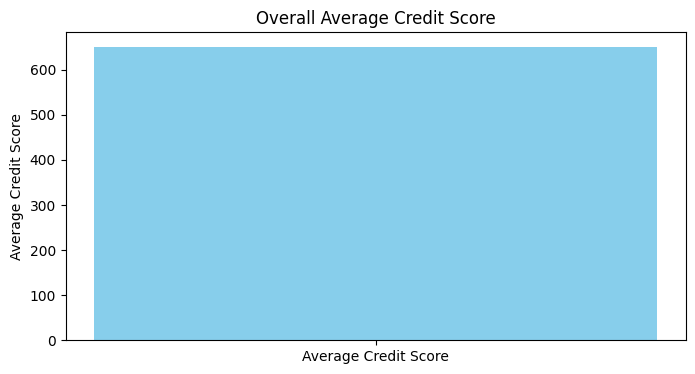

In [18]:
import matplotlib.pyplot as plt

# Assume df_avg_credit_score is the DataFrame from the average credit score query
plt.figure(figsize=(8, 4))
plt.bar(["Average Credit Score"], [df_avg_credit_score['avg_credit_score'][0]], color='skyblue')
plt.ylabel("Average Credit Score")
plt.title("Overall Average Credit Score")
plt.show()

📌 **Best Practice**:  
✔️ Encapsulates query execution inside a **function** for efficiency.  
✔️ Names each DataFrame meaningfully for easy reference.  






## **6️⃣ Next Steps & Production Considerations 🚀** 


### **🎯 Enhancing SQL Queries**
🔹 Identify **key features** correlated with churn.  
🔹 Apply **window functions, joins, and aggregations** for advanced insights.  
🔹 Perform **data transformations** inside BigQuery before fetching results.  

### **📈 Visualization & EDA**
🔹 Use **matplotlib & seaborn** to visualize churn distribution.  
🔹 Compare **churned vs. retained customers** across different variables.  

### **🔄 CI/CD & Deployment**
🔹 Automate query execution using **GitHub Actions**.  
🔹 Integrate results into a **dashboard or API**.  

---

This structured approach ensures that our notebook remains **organized, efficient, and production-ready**. 🚀🔍  